## Bibliotecas

In [97]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [98]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


## Download e Preparação do Dataset

In [99]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [100]:
train_dataset = CIFAR10(root='data/', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='data/', train=False, transform=transform, download=True)

In [101]:
train_size = 40000
val_size = 10000

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [102]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [103]:
for images, labels in val_loader:
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 32, 32]) torch.Size([32])


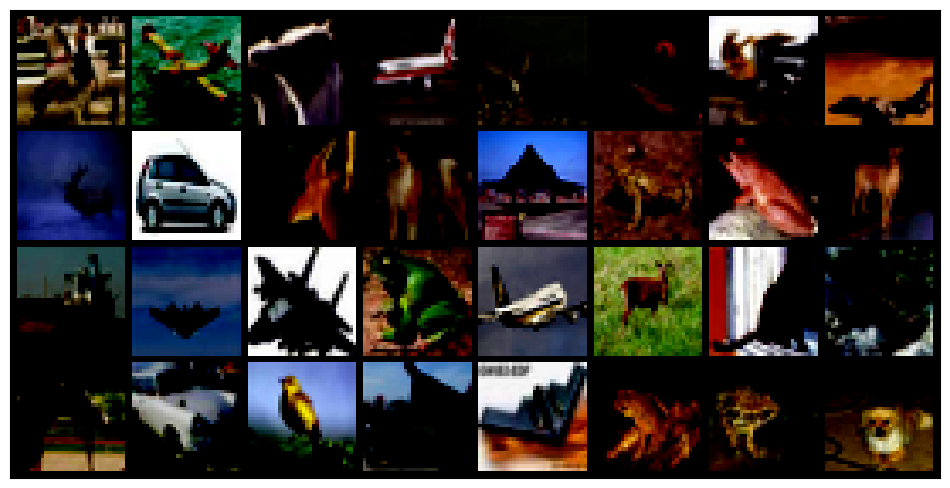

In [104]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        plt.show()
        break

show_batch(train_loader)

## Modelo

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():  # sem cálculo de gradiente na val
            out = self(images)
            loss = F.cross_entropy(out, labels)
            acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], train_loss: {result['train_loss']:.4f}, "
              f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [106]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 32x32 -> 16x16
            nn.Dropout(0.25),


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 16x16 -> 8x8
            nn.Dropout(0.25),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 8x8 -> 4x4
            nn.Dropout(0.4),


            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, xb):
        return self.network(xb)

## Treinamento

In [107]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer =   opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        count = 0

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            count += 1

        result = evaluate(model, val_loader)
        result['train_loss'] = train_loss / count
        model.epoch_end(epoch, result)
        history.append(result)

        import gc
        gc.collect()
        torch.cuda.empty_cache()

    return history


In [108]:
model = CIFAR10Model()

In [109]:
model = model.to(device)

In [110]:
import torch.optim as optim

num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001


history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [1], train_loss: 1.5582, val_loss: 1.1571, val_acc: 0.5796
Epoch [2], train_loss: 1.2131, val_loss: 0.9825, val_acc: 0.6487
Epoch [3], train_loss: 1.0590, val_loss: 0.8634, val_acc: 0.6973
Epoch [4], train_loss: 0.9552, val_loss: 0.7988, val_acc: 0.7190
Epoch [5], train_loss: 0.8810, val_loss: 0.7018, val_acc: 0.7508
Epoch [6], train_loss: 0.8155, val_loss: 0.6734, val_acc: 0.7618
Epoch [7], train_loss: 0.7720, val_loss: 0.6445, val_acc: 0.7755
Epoch [8], train_loss: 0.7198, val_loss: 0.6856, val_acc: 0.7676
Epoch [9], train_loss: 0.6715, val_loss: 0.6115, val_acc: 0.7926
Epoch [10], train_loss: 0.6417, val_loss: 0.5798, val_acc: 0.8062
Epoch [11], train_loss: 0.6160, val_loss: 0.5698, val_acc: 0.8067
Epoch [12], train_loss: 0.5874, val_loss: 0.5736, val_acc: 0.8099
Epoch [13], train_loss: 0.5661, val_loss: 0.5377, val_acc: 0.8184
Epoch [14], train_loss: 0.5448, val_loss: 0.5216, val_acc: 0.8209
Epoch [15], train_loss: 0.5194, val_loss: 0.5105, val_acc: 0.8297
Epoch [16], train_l

## Avaliação dos Resultados

In [111]:
def plot_accuracies(history):
    """ Plot the history of validation accuracies """
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(8,5))
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Epochs')
    plt.grid(True)
    plt.show()


def plot_losses(history):
    """ Plot training and validation losses """
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, '-bx', label='Training Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

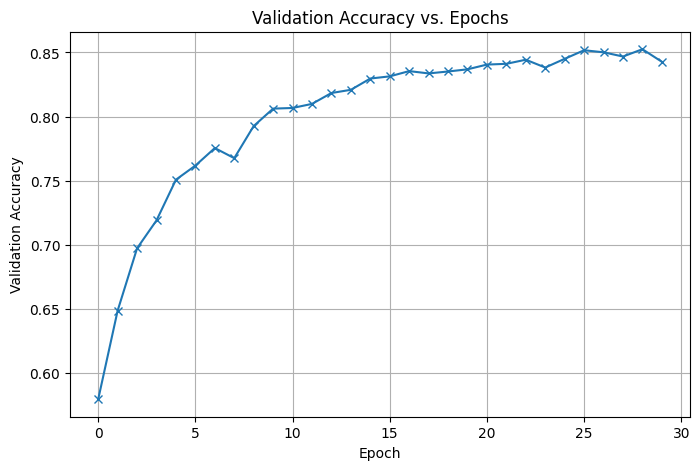

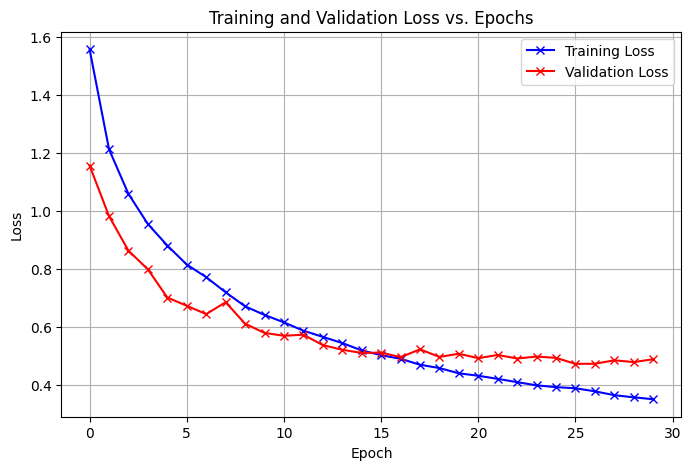

In [112]:
plot_accuracies(history)
plot_losses(history)

In [113]:
model.eval()

test_result = evaluate(model, test_loader)
print(f"Test Loss: {test_result['val_loss']:.4f}, Test Accuracy: {test_result['val_acc']:.4f}")

Test Loss: 0.4888, Test Accuracy: 0.8467


In [114]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

print("Predições:", preds.cpu().numpy())
print("Labels reais:", labels.cpu().numpy())

Predições: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 9 8 6 7 0 4 9 4 6 3 0 9 6 6 5]
Labels reais: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5]


In [115]:
def imshow_grid(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.cpu().numpy()
    return np.transpose(npimg, (1, 2, 0))

In [116]:
classes = test_dataset.classes

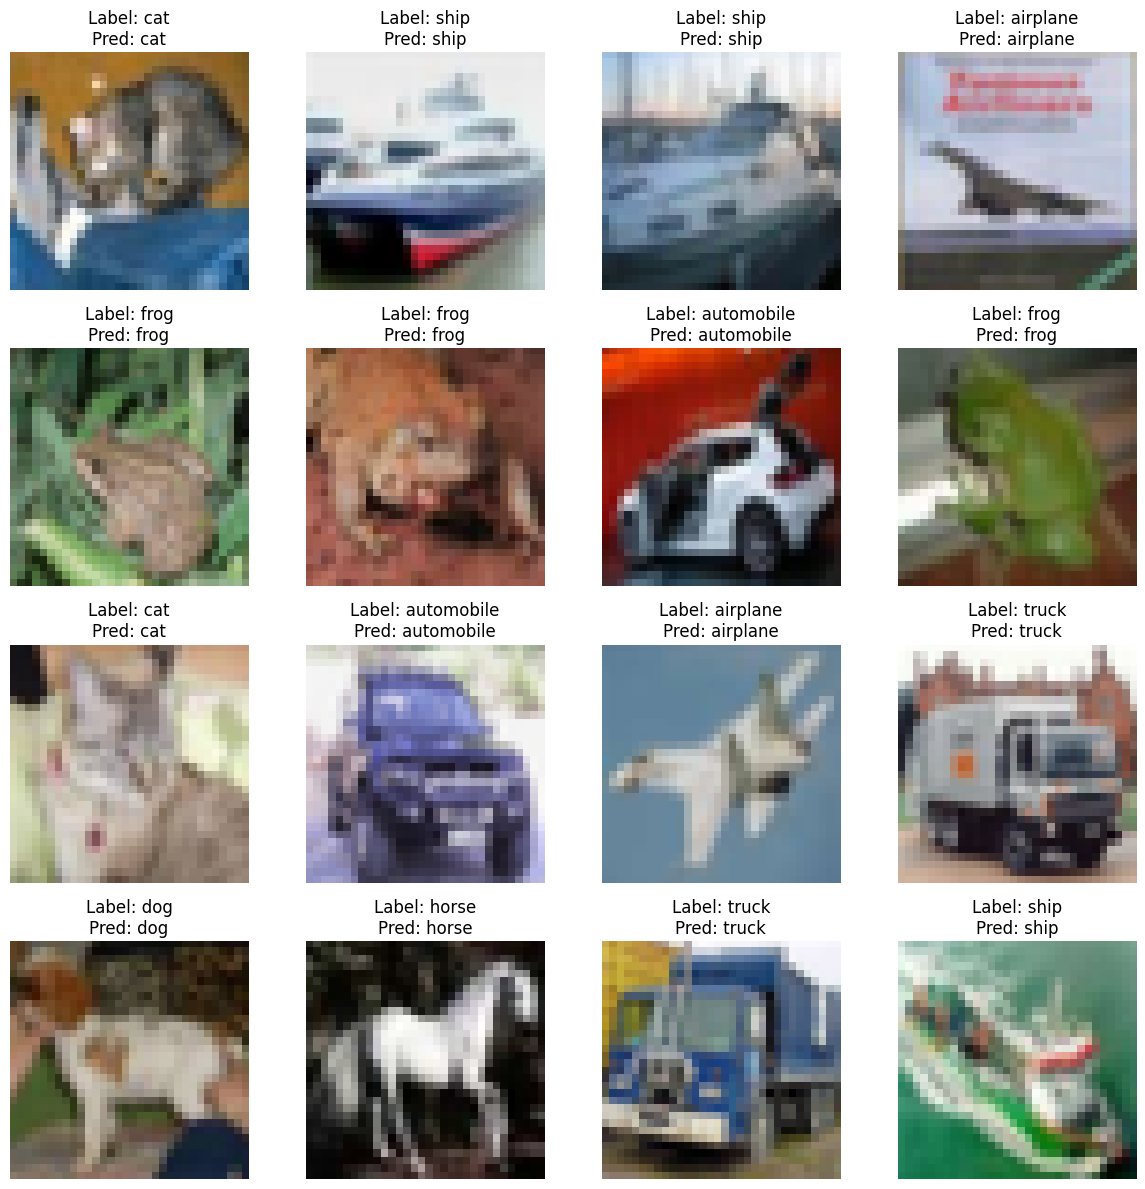

In [117]:
num_images = 16
plt.figure(figsize=(12,12))

for i in range(num_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(imshow_grid(images[i]))
    plt.title(f"Label: {classes[labels[i].item()]}\nPred: {classes[preds[i].item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()